In [1]:
!pip install torchmetrics[detection]
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 11.3 MB/s eta 0:00:0000:01


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random

import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.mean_ap import MeanAveragePrecision

from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
THRESHOLD = 0.95
BATCH_SIZE = 8

### Dataset definition

In [5]:
class BallDetectionDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        with open(annotations_file, 'r') as file:
            data = json.load(file)
            self.img_paths = list(data.keys())
            self.img_annots = list(data.values())

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])       
        annot = self.img_annots[idx]
        
        image = Image.open(img_path, mode='r')
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        w, h = image.shape[1:]
        
        boxes = []
        for bbox in self.img_annots[idx]:
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])
            
        boxes = np.asarray(boxes)  # N x 4
        
        target = {}
        target['boxes'] = torch.Tensor(boxes)
        target['labels'] = torch.ones((len(boxes),), dtype=torch.int64)
        
        return image, target

In [6]:
def collater(data):
    imgs = []
    targets = []
    
    for image, target in data:
        imgs.append(image)
        targets.append(target)
        
    imgs = torch.stack(imgs, dim=0)
    
    return imgs, targets

### Train definition

In [8]:
def train(model, optimizer, epoch):
    train_transform = transforms.Compose([
        transforms.transforms.GaussianBlur(kernel_size=3),
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])

    training_data = BallDetectionDataset(
        annotations_file='/kaggle/input/hw6-dataset-of-balls/oi5_ball_filename_to_bbox_train.json',
        img_dir='/kaggle/input/hw6-dataset-of-balls/',
        transform=train_transform,
    )

    train_dataloader = DataLoader(training_data, 
        batch_size=BATCH_SIZE,                       
        collate_fn=collater
    )
    
    metric = MeanAveragePrecision(box_format='xyxy')
    
    print_freq = int(1200 / BATCH_SIZE)
    model.train()
    
    for i, (imgs, targets) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        targets = [{key: value.to(device) for key, value in target.items()} for target in targets]

        loss_dict = model(imgs, targets)
        loss = sum(list(loss_dict.values()))

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
            
        if i and i % print_freq == 0:
            model.eval()
            mAP = metric(model(imgs), targets)['map'].item()
            model.train()
            
            print(f'Epoch: [{epoch}]:\tLoss = {loss:.4f},\tmAP = {mAP:.4f}')
            del mAP
            
        del imgs, targets, loss_dict, loss

## Training

In [9]:
model = fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True, progress=True)

model.roi_heads.box_predictor = FastRCNNPredictor(
    in_channels=model.roi_heads.box_predictor.cls_score.in_features, 
    num_classes=2
)

for param in model.parameters():
    param.requires_grad = False

for parameters in [model.roi_heads.parameters(), model.backbone.body.layer4.parameters(), model.backbone.fpn.parameters()]:
    for param in parameters:
        param.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weigh

In [10]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

In [11]:
for i in range(4):
    train(model, optimizer, i)

Epoch: [0]:	Loss = 0.6051,	mAP = 0.0329
Epoch: [0]:	Loss = 0.3610,	mAP = 0.1049
Epoch: [1]:	Loss = 0.5306,	mAP = 0.1596
Epoch: [1]:	Loss = 0.2796,	mAP = 0.1659
Epoch: [2]:	Loss = 0.5085,	mAP = 0.2300
Epoch: [2]:	Loss = 0.3159,	mAP = 0.1966
Epoch: [3]:	Loss = 0.4372,	mAP = 0.2555
Epoch: [3]:	Loss = 0.3206,	mAP = 0.2335


## Validation

In [12]:
def select_over_threshold(result, threshold):
    selected_results = []

    for i, res in enumerate(result):
        selected_boxes = []
        selected_scores = []
        selected_labels = []

        for box, label, score in zip(res['boxes'], res['labels'], res['scores']):
            if score > threshold:
                selected_boxes.append(box)
                selected_scores.append(score)
                selected_labels.append(label)
                
        if selected_boxes:
            selected_results.append({
                'boxes': torch.stack(selected_boxes, dim=0).to(device), 
                'scores': torch.Tensor(selected_scores).to(device),
                'labels': torch.Tensor(selected_labels).to(device)
            })
        else:
            selected_results.append(None)
        
    return selected_results

In [13]:
def visualize_boxes(image, boxes):
    if not len(boxes):
        return
    
    palette = sns.color_palette(None, 1)
    
    mean = np.array([0.406, 0.485, 0.456])
    std = np.array([0.225, 0.229, 0.224])
    
    image = image.permute([1, 2, 0]).numpy()
    image = np.ascontiguousarray(np.clip(image * std + mean, 0, 1), dtype=np.float64)

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color=np.array(palette[0]), thickness=3)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [14]:
val_transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

val_data = BallDetectionDataset(
    annotations_file='/kaggle/input/hw6-dataset-of-balls/oi5_ball_filename_to_bbox_val.json',
    img_dir='/kaggle/input/hw6-dataset-of-balls/',
    transform=val_transform
)

val_dataloader = DataLoader(
    val_data, 
    batch_size=BATCH_SIZE,                        
    collate_fn=collater
)

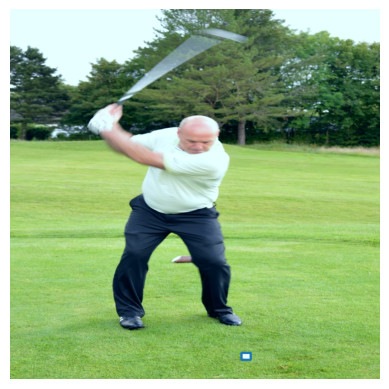

In [20]:
image, target = next(iter(val_dataloader))
visualize_boxes(image[3], target[3]['boxes'])

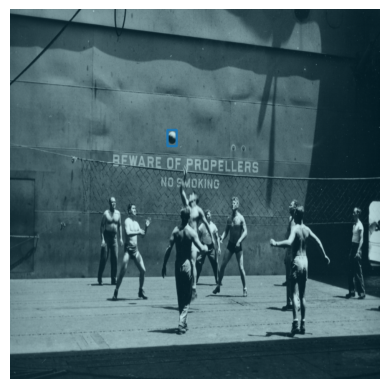

In [24]:
model.to(torch.device('cpu'))
model.eval()
selected_result = select_over_threshold(model((image[0], )), THRESHOLD)

visualize_boxes(image[0], selected_result[0]['boxes'])

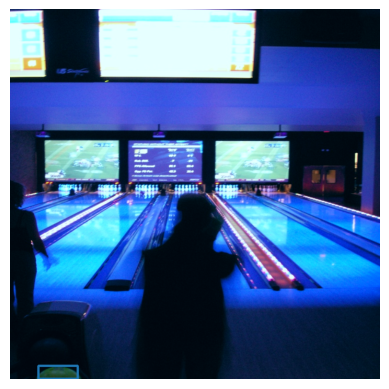

In [27]:
visualize_boxes(image[1], target[1]['boxes'])

In [26]:
selected_result = select_over_threshold(model((image[1], )), THRESHOLD)

visualize_boxes(image[1], selected_result[0]['boxes']) # не было найдено мячей с текущим THRESHOLD, но это и очевидно

TypeError: 'NoneType' object is not subscriptable

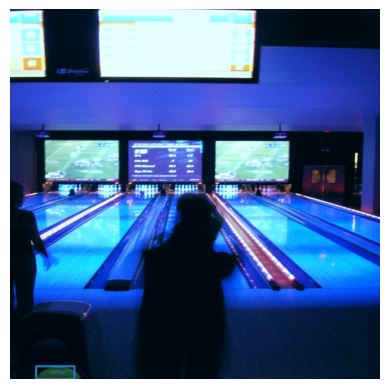

In [31]:
selected_result = select_over_threshold(model((image[1], )), 0.32)

visualize_boxes(image[1], selected_result[0]['boxes']) # с меньшим значением threahold все норм

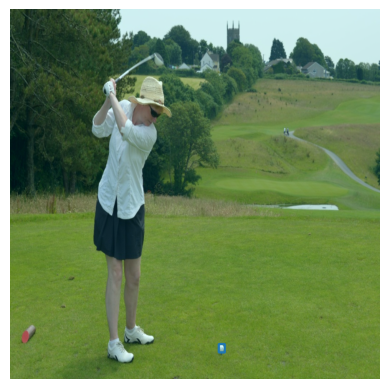

In [32]:
visualize_boxes(image[2], target[2]['boxes'])

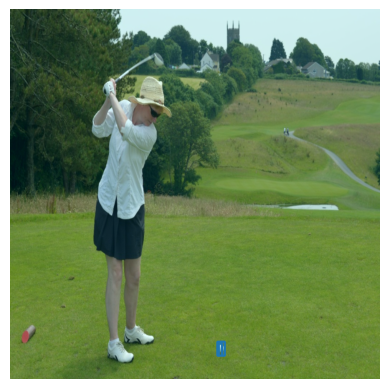

In [33]:
selected_result = select_over_threshold(model((image[2], )), THRESHOLD)

visualize_boxes(image[2], selected_result[0]['boxes'])